<a href="https://colab.research.google.com/github/seema469/AAI_511_DeepLearning/blob/main/composer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">Classification of Composers Using Convolutional and Long Short-Term Memory Networks</h1>


This project seeks to accurately predict classical composers like Bach, Beethoven, Chopin and Mozart from musical scores using Long Short-Term Memory (LSTM) and Convolutional Neural Networks (CNN) models, addressing the challenges novice listeners face in distinguishing these composers.

Classical music intricately blends art with mathematical principles, presenting a unique opportunity for Machine Learning (ML) application. This project extends these principles to develop AI tools that enhance understanding and appreciation of classical music, serving both educational and analytical purposes in the field.

The project is divided into two distinct sections, each addressing a different computational approache.
1) CNN to analyze structural patterns and extract foundational features.
3) LSTM using fixed sequence tokens to identify and learn distinct, recurring pitch and pitch variations unique to each composer.

### Setup

#### Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install pretty_midi
!pip install pyfluidsynth
!apt-get install fluidsynth
!apt-get install graphviz
!pip install graphviz pydot

#### Imports

In [ ]:
import tensorflow as tf
import os
import numpy as np
import pretty_midi
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
from IPython import display
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix,classification_report
import seaborn as sns
import pickle
from scipy.stats import mode

# Set seed
np.random.seed(42)

#### Define globals

In [ ]:
data_directory = './/data'
# Define the sampling rate
_SAMPLING_RATE = 44100  # Standard audio sampling rate
# SEquence lenght for pitch
sequence_length = 100

### Data Pre-processing


#### Helper functions

In [ ]:
# Function to load midi files, composer labels and compser map in seperate arrays

def load_midi_data_and_labels(directory):
    skipped_files = []    # Keep track of skipped files due to errors
    data = []
    composers = []
    num_composer_map = {}
    # Function to recursively iterate files in a directory
    def iterate_dir(dir_path, label, composer):
        # Check direct .mid files in current directory
        for item in os.listdir(dir_path):
            item_path = os.path.join(dir_path, item)
            if os.path.isfile(item_path) and item_path.endswith('.mid'):
                try:
                    # Load the MIDI file
                    midi_data = pretty_midi.PrettyMIDI(item_path)
                    data.append(midi_data)
                    composers.append(label)
                except Exception as e:  # Catch any exception that might be raised
                    print(f"Skipping file {item_path} due to an error: {e}")
                    skipped_files.append(item_path)
            elif os.path.isdir(item_path):
                iterate_dir(item_path, label, composer)
        print(f"Number of files skipped due to error: {len(skipped_files)}")
        return

    # Process each composer's directory in the root directory
    for label, composer in enumerate(sorted(os.listdir(directory))):
        composer_path = os.path.join(directory, composer)
        if os.path.isdir(composer_path):
            num_composer_map[label] = composer
            iterate_dir(composer_path, label, composer)

    return np.array(data), np.array(composers), num_composer_map


In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
# Load midi files. Skip the erroneous files.
midi_data, composer_labels, composer_map = load_midi_data_and_labels(data_directory)

In [ ]:
# Shuffel midi_data, composer_label few times
for i in range(2):
  print("Shuffel:", i)
  # shuffled indices
  indices = np.arange(midi_data.shape[0])
  np.random.shuffle(indices)

  # Shuffling both midi_data and composer_labels_in using same indices
  midi_data = midi_data[indices]
  composer_labels = composer_labels[indices]

Shuffel: 0
Shuffel: 1


In [ ]:
midi_data.shape

(1528,)

In [ ]:
# Play first loaded midi file
#display_audio(midi_data[0])

### Data Augmentation

To address dataset imbalance, we augmented our training data for composers Beethoven, Mozart, and Chopin by applying data augmentation techniques like time stretching to MIDI files, thereby maintaining pitch but altering tempo. This increased the data volume and variety, capturing a broader stylistic spectrum. Simultaneously, we reduced the over-represented Bach files to balance the dataset, ensuring our model trains evenly across various composers, minimizing stylistic biases and improving its generalization capabilities.

In [ ]:
# Function to change note's temoral feature
def time_stretch_midi(data, stretching_factor):
    new_midi = copy_midi(data)
    for instrument in new_midi.instruments:
        for note in instrument.notes:
            note.start *= stretching_factor
            note.end *= stretching_factor
    return new_midi

In [ ]:
import copy

# Function to do deep copying newly created MIDI files

def copy_midi(original_midi):
    # Create a deep copy of the original MIDI data
    copied_midi = copy.deepcopy(original_midi)
    return copied_midi

In [ ]:
# To create new midi files for a composer, we will choose randomly selected sample_percentage midi files for a specific composer and then
# use those indexes to augment new midi files using specific feature like note's duration.


# Helper function to create new midi files
def augment_extend_composer_midi_files(composer_labels, composer_label, sample_percentage=0.25):
    # Find indices where composer_labels match the desired composer_label
    indices = np.where(composer_labels == composer_label)[0]
    # Randomly select sample from these indices
    sampled_indices = np.random.choice(indices, len(indices), replace=False)
    # take sample_percentage % of the sampled_indices
    sample_size = int(len(sampled_indices) * sample_percentage)
    return sampled_indices[0:sample_size]


In [ ]:
# Helper function to skip midi files
def augment_skip_composer_midi_files(composer_labels, composer_label, skip_percentage=0.50):
    # Find indices where composer_labels match the desired composer_label
    indices = np.where(composer_labels == label_bach)[0]
    # Randomly select sample from these indices
    sampled_indices = np.random.choice(indices, len(indices), replace=False)
    sample_size = int(len(sampled_indices) * skip_percentage)
    skip_indices = sampled_indices[0:sample_size]
    return skip_indices

In [ ]:
unique_composer, counts = np.unique(composer_labels, return_counts=True)
print("Before MIDI file augmentaion:")
for composer, count in zip(unique_composer, counts):
    print(f'composer: {composer_map[composer]},  Sample Size: {count}')

Before MIDI file augmentaion:
composer: Bach,  Sample Size: 925
composer: Beethoven,  Sample Size: 211
composer: Chopin,  Sample Size: 136
composer: Mozart,  Sample Size: 256


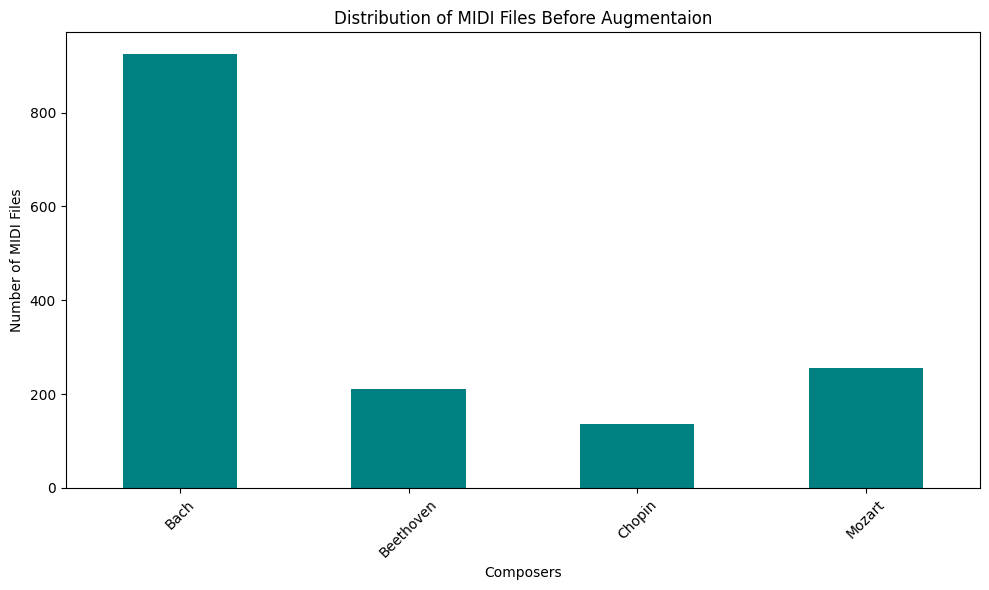

In [ ]:
# Plot MIDI data distribution before augmentaion
# Convert list to pandas Series
composer_series = pd.Series(composer_labels)
# Count of each label
label_counts = composer_series.value_counts().sort_index()
# Map label counts to composer names
composer_counts = label_counts.rename(index=composer_map)

# Plotting the data
plt.figure(figsize=(10, 6))
composer_counts.plot(kind='bar', color='teal')
plt.xlabel('Composers')
plt.ylabel('Number of MIDI Files')
plt.title('Distribution of MIDI Files Before Augmentaion')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

In [ ]:
# Augmentation - skip 60% of midi_files for Bach
skip_percentage = 0.60
label_bach = 0
data_reduced = []
labels_reduced = []
skip_indices = augment_skip_composer_midi_files(composer_labels, label_bach, skip_percentage)
# Remove elements at specified indices
data_reduced = np.delete(midi_data, skip_indices)
labels_reduced = np.delete(composer_labels, skip_indices)

In [ ]:
unique_composer, counts = np.unique(labels_reduced, return_counts=True)
print("After Bach MIDI files removed:")
for composer, count in zip(unique_composer, counts):
    print(f'composer: {composer_map[composer]},  sample size: {count}')

After Bach MIDI files removed:
composer: Bach,  sample size: 370
composer: Beethoven,  sample size: 211
composer: Chopin,  sample size: 136
composer: Mozart,  sample size: 256


In [ ]:
composer_map

{0: 'Bach', 1: 'Beethoven', 2: 'Chopin', 3: 'Mozart'}

In [ ]:
# Augmentation - create new 50% of midi_files for Beethoven, Chopin, and Mozart
data_extended = []
labels_extended = []

# Get the labels of composer for which midi_files need to be augmented
extend_midifiles_for = []
for key, value in composer_map.items():
        if value == 'Beethoven' or value == 'Chopin' or value == 'Mozart':
            extend_midifiles_for.append(key)

In [ ]:
# Append the new midi files and labels in lists

def augment_MIDI_temporal(composer_labels, composer_label_index, extend_percentage, time_stretch):
    composer_indices = augment_extend_composer_midi_files(composer_labels, composer_label_index, extend_percentage)
    print("Composer ", composer_map[composer_label_index], "sample size = ", len(composer_indices))
    for i in composer_indices:
        stretched_midi = time_stretch_midi(midi_data[i], time_stretch)
        data_extended.append(stretched_midi)
        labels_extended.append(composer_label_index)

#Beethoven: augment 55% more than the current capacity by temoral reduction to 50%.
augment_MIDI_temporal(composer_labels, composer_label_index=1, extend_percentage = 0.55, time_stretch = 0.50) # reduce 50%
#Chopin: augment 100% more (double) than the current capacity by temoral reduction to 50%.
augment_MIDI_temporal(composer_labels, composer_label_index=2, extend_percentage = 1.0, time_stretch = 0.50)
#Mozart : augment 40% more than the current capacity by temoral reduction to 50%.
augment_MIDI_temporal(composer_labels, composer_label_index=3, extend_percentage = 0.40, time_stretch = 0.50)
#Chopin : augment 50% more than the current capacity by temoral increment to 50%.
augment_MIDI_temporal(composer_labels, composer_label_index=2, extend_percentage = 0.5, time_stretch = 1.50) # increase 50%


Composer  Beethoven sample size =  116
Composer  Chopin sample size =  136
Composer  Mozart sample size =  102
Composer  Chopin sample size =  68


In [ ]:
#display_audio(data_extended[0])

In [ ]:
midi_data_augmented = []
composer_labels_augmented = []
midi_data_augmented = np.append(data_reduced, data_extended)
composer_labels_augmented = np.append(labels_reduced, labels_extended)

In [ ]:
print(midi_data_augmented.shape)
print(len(composer_labels_augmented))

(1395,)
1395


In [ ]:
unique_composer, counts = np.unique(composer_labels_augmented, return_counts=True)
print("After MIDI file augmentaion:")
for composer, count in zip(unique_composer, counts):
    print(f'composer: {composer_map[composer]},  sample size: {count}')

After MIDI file augmentaion:
composer: Bach,  sample size: 370
composer: Beethoven,  sample size: 327
composer: Chopin,  sample size: 340
composer: Mozart,  sample size: 358


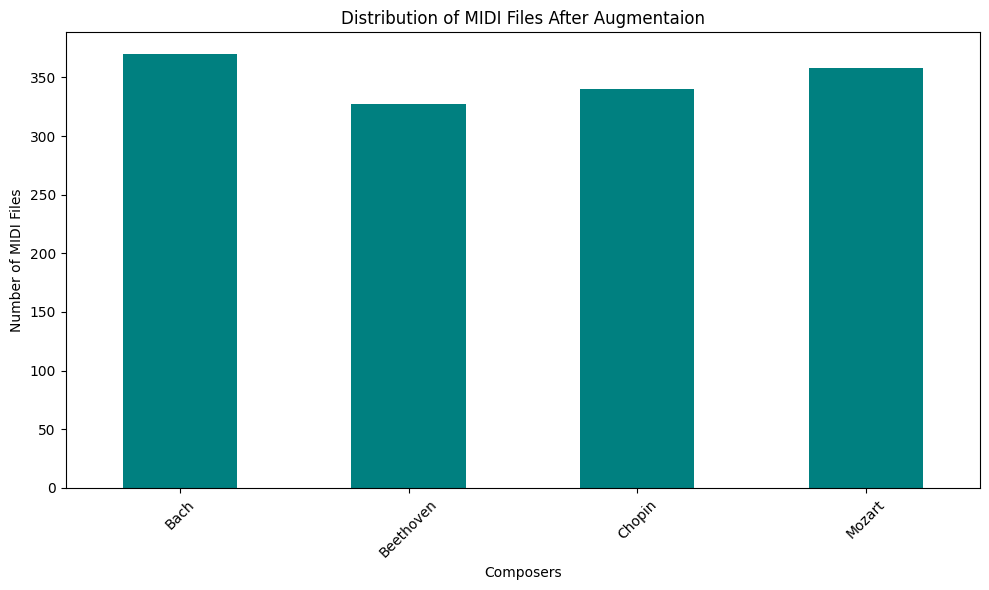

In [ ]:
# Plot MIDI data distribution after augmentaion

# Convert list to pandas Series
composer_series = pd.Series(composer_labels_augmented)
# Count of each label
label_counts = composer_series.value_counts().sort_index()
# Map label counts to composer names
composer_counts = label_counts.rename(index=composer_map)

# Plotting the data
plt.figure(figsize=(10, 6))
composer_counts.plot(kind='bar', color='teal')
plt.xlabel('Composers')
plt.ylabel('Number of MIDI Files')
plt.title('Distribution of MIDI Files After Augmentaion')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

## EDA

In [ ]:
import os
import mido
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def extract_midi_info(midi_file):
    """
    Extract basic information from a MIDI file.
    """
    try:
        midi_data = mido.MidiFile(midi_file)
        info = {
            'filename': os.path.basename(midi_file),
            'filepath': midi_file,
            'length': midi_data.length,
            'tracks': len(midi_data.tracks),
            'ticks_per_beat': midi_data.ticks_per_beat
        }
        return info
    except Exception as e:
        print(f"Error processing {midi_file}: {e}")
        return None

def read_midi_files(directory):
    """
    Recursively read all MIDI files in a directory and its subdirectories and extract information.
    """
    midi_info_list = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.mid') or file.endswith('.midi'):
                print(root,file)
                midi_file = os.path.join(root, file)
                midi_info = extract_midi_info(midi_file)
                if midi_info:
                    midi_info_list.append(midi_info)
    return pd.DataFrame(midi_info_list)

# Example usage:
midi_directory = r"archive\\midiclassics"
midi_df = read_midi_files(midi_directory)

archive\\midiclassics Bartok Suite 1mov.mid
archive\\midiclassics Bartok Suite 2mov.mid
archive\\midiclassics Bizet Carmen Prelude.mid
archive\\midiclassics Bizet Symphony in C 1mov.mid
archive\\midiclassics Bizet Symphony in C 2mov.mid
archive\\midiclassics Bizet Symphony in C 3mov.mid
archive\\midiclassics Bizet Symphony in C 4mov.mid
archive\\midiclassics Buxethude Buxwv136 Prelude.mid
archive\\midiclassics Buxethude Buxwv138 Prelude.mid
Error processing archive\\midiclassics\Buxethude Buxwv138 Prelude.mid: list index out of range
archive\\midiclassics Buxethude Buxwv145 Prelude.mid
archive\\midiclassics Buxethude Buxwv153 Prelude.mid
archive\\midiclassics Buxethude Buxwv155 Toccata.mid
archive\\midiclassics Buxethude Buxwv156 Toccata.mid
archive\\midiclassics Buxethude Buxwv157 Tocatta and Fugue.mid
archive\\midiclassics Buxethude Buxwv157 Toccata.mid
archive\\midiclassics Buxethude Buxwv158 Preambulum.mid
archive\\midiclassics Buxethude Buxwv160 Ciacona.mid
archive\\midiclassics B

In [ ]:
midi_df.head()

,filename,filepath,length,tracks,ticks_per_beat
0,Bartok Suite 1mov.mid,archive\\midiclassics\Bartok Suite 1mov.mid,120.995515,1,1024
1,Bartok Suite 2mov.mid,archive\\midiclassics\Bartok Suite 2mov.mid,105.217808,1,1024
2,Bizet Carmen Prelude.mid,archive\\midiclassics\Bizet Carmen Prelude.mid,195.434774,28,120
3,Bizet Symphony in C 1mov.mid,archive\\midiclassics\Bizet Symphony in C 1mov...,640.325161,20,120
4,Bizet Symphony in C 2mov.mid,archive\\midiclassics\Bizet Symphony in C 2mov...,561.271014,20,120


In [ ]:
# Display basic statistics
print(midi_df.describe())

            length       tracks  ticks_per_beat
count  3830.000000  3830.000000     3830.000000
mean    235.022634     7.983812      390.268407
std     266.670424     6.399411      312.856318
min      13.125000     1.000000       24.000000
25%      73.934092     4.000000      120.000000
50%     152.885402     5.000000      240.000000
75%     290.000000    11.000000      480.000000
max    5209.310787   140.000000     1024.000000


            length       tracks  ticks_per_beat
count  3830.000000  3830.000000     3830.000000
mean    235.022634     7.983812      390.268407
std     266.670424     6.399411      312.856318
min      13.125000     1.000000       24.000000
25%      73.934092     4.000000      120.000000
50%     152.885402     5.000000      240.000000
75%     290.000000    11.000000      480.000000
max    5209.310787   140.000000     1024.000000


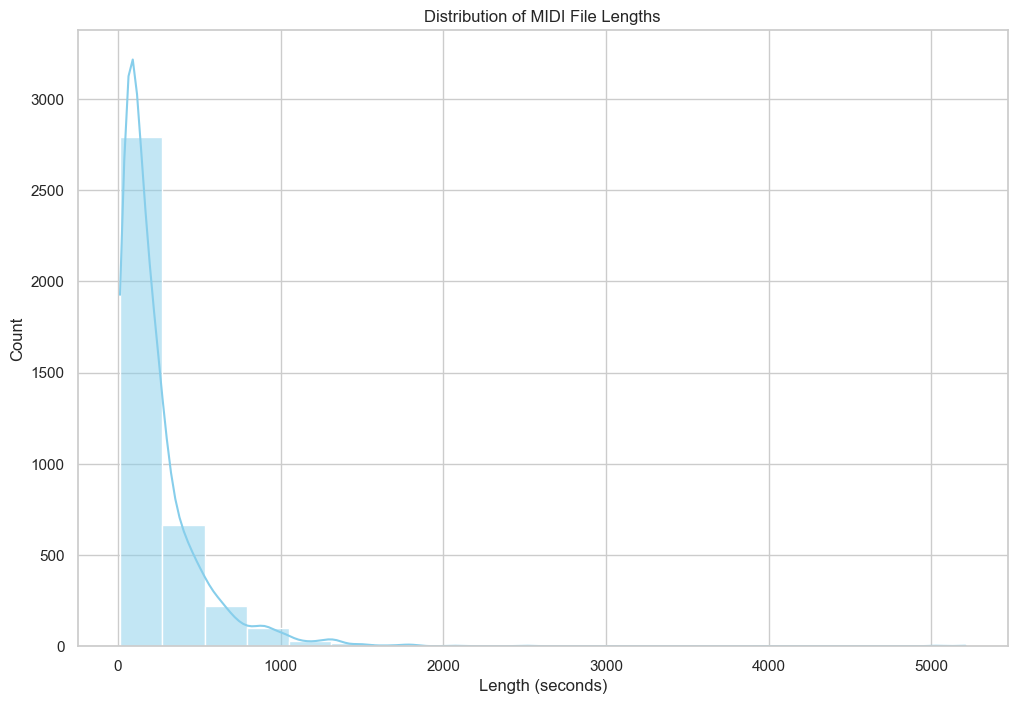

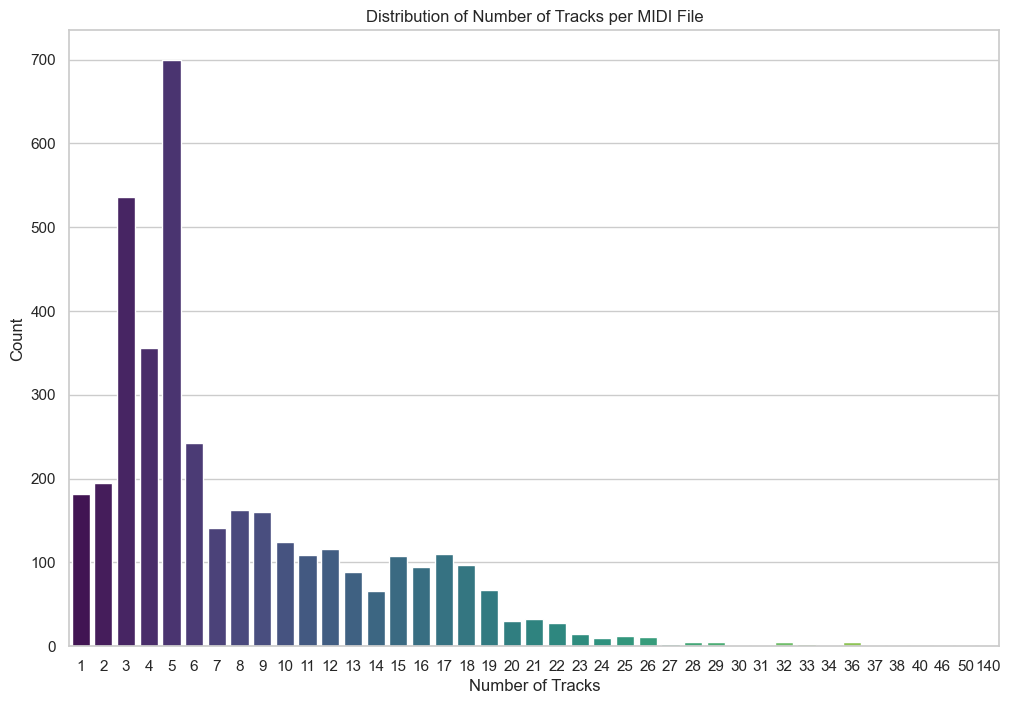

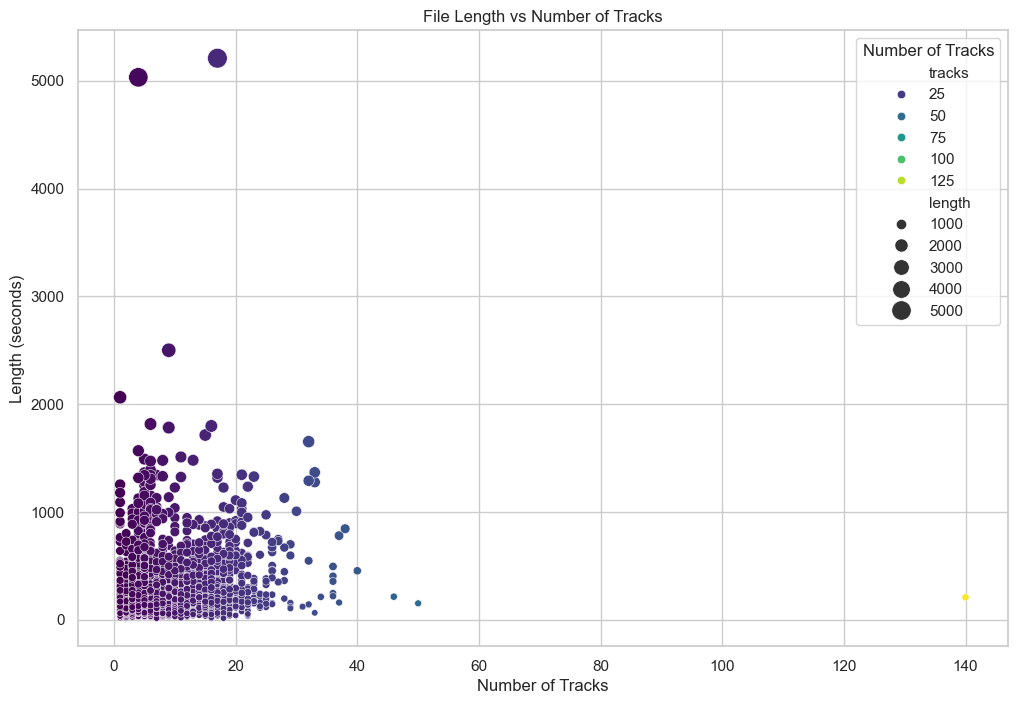

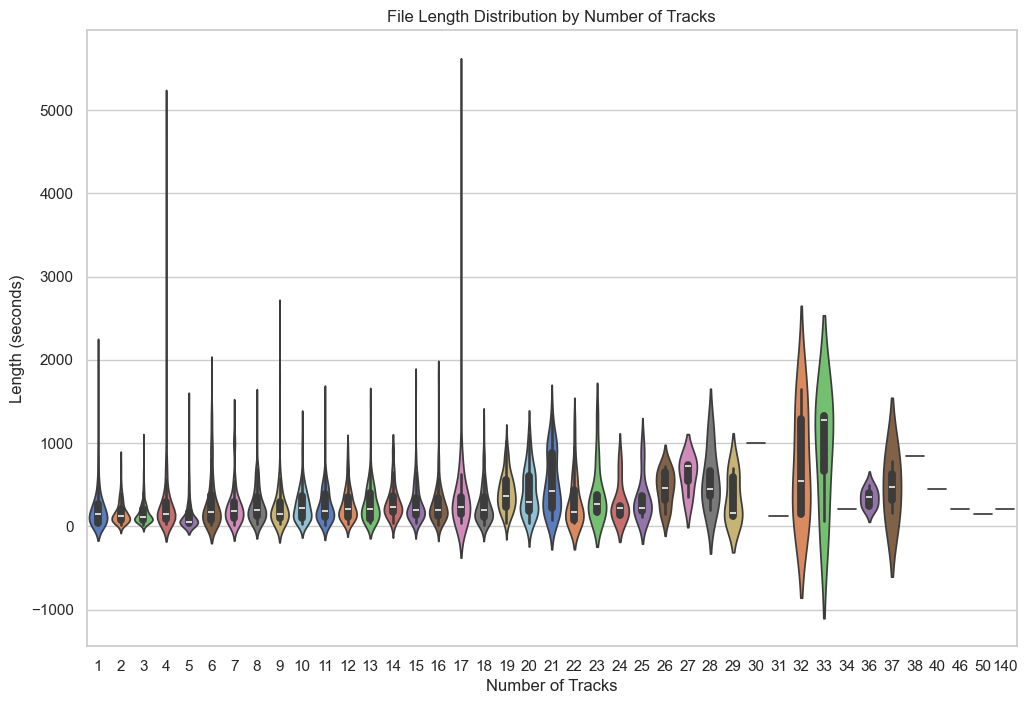

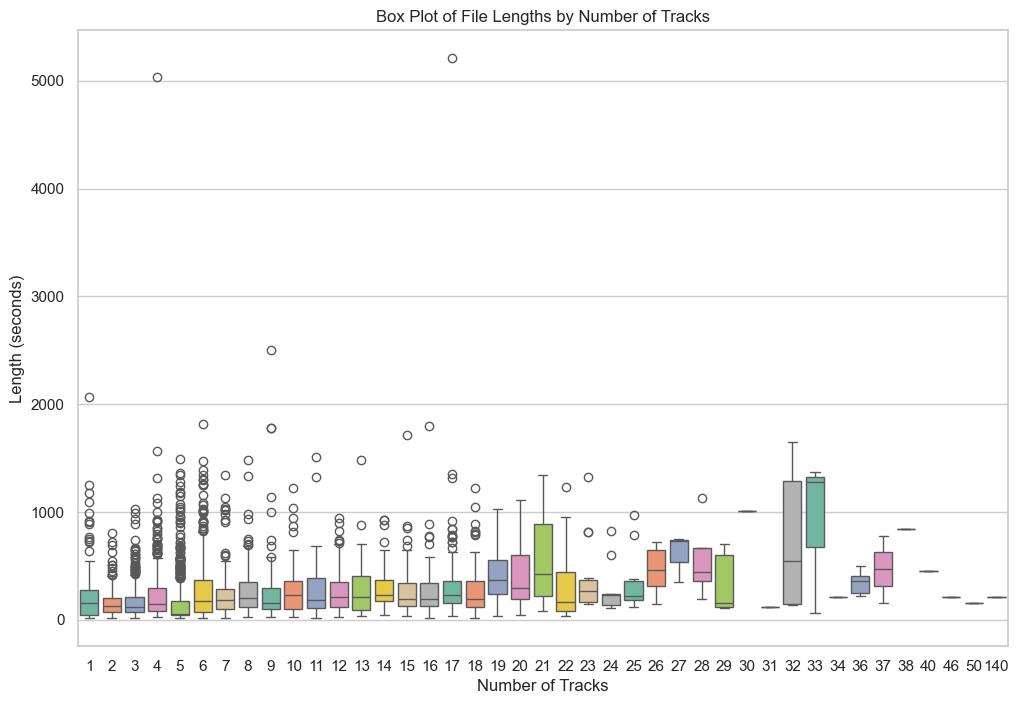

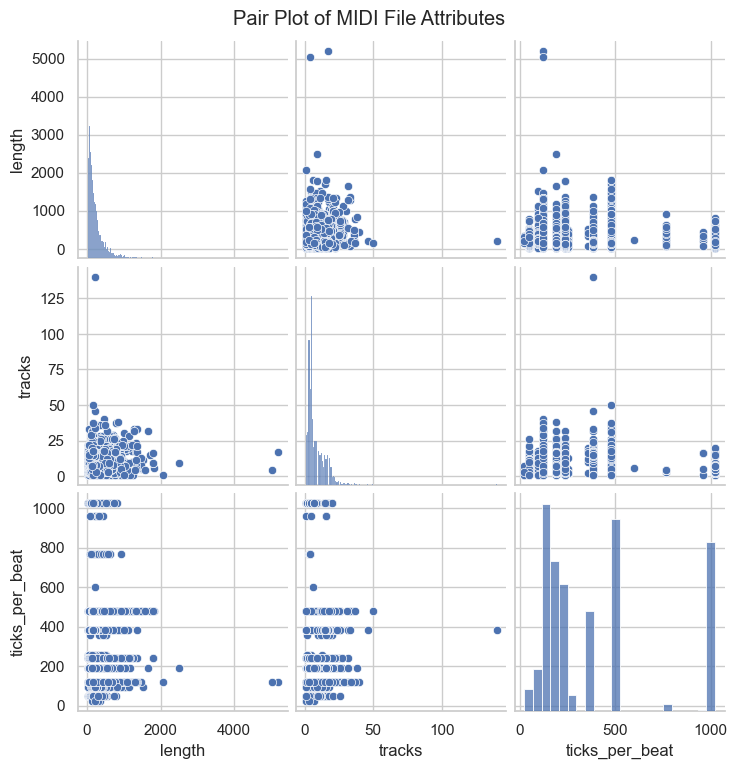

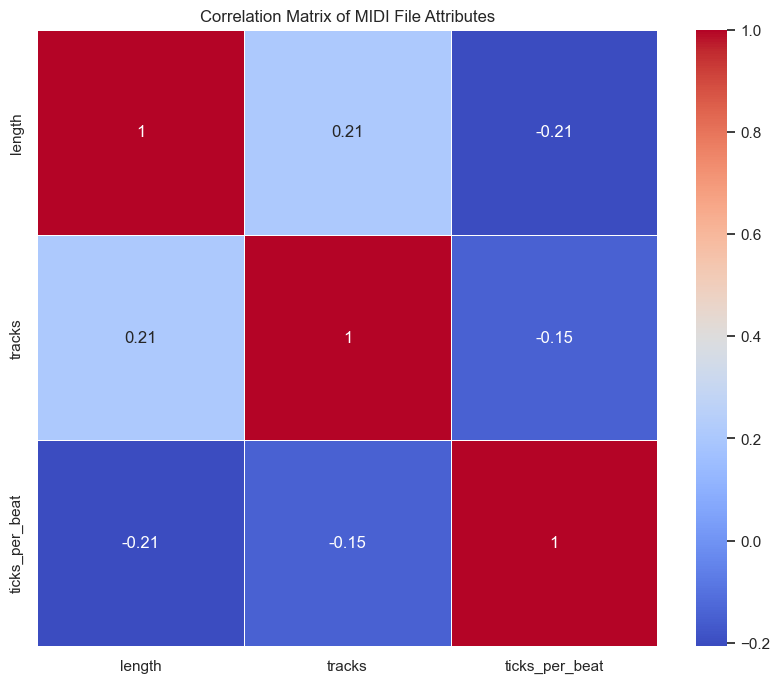

In [ ]:
# Set a visual style
sns.set(style="whitegrid")

# Display basic statistics
print(midi_df.describe())

# Plot distribution of MIDI file lengths
plt.figure(figsize=(12, 8))
sns.histplot(midi_df['length'], bins=20, kde=True, color="skyblue")
plt.title('Distribution of MIDI File Lengths')
plt.xlabel('Length (seconds)')
plt.ylabel('Count')
plt.show()

# Plot distribution of the number of tracks per MIDI file
plt.figure(figsize=(12, 8))
sns.countplot(data=midi_df, x='tracks', palette="viridis")
plt.title('Distribution of Number of Tracks per MIDI File')
plt.xlabel('Number of Tracks')
plt.ylabel('Count')
plt.show()

# Scatter plot of file length vs number of tracks
plt.figure(figsize=(12, 8))
sns.scatterplot(data=midi_df, x='tracks', y='length', hue='tracks', palette="viridis", size='length', sizes=(20, 200))
plt.title('File Length vs Number of Tracks')
plt.xlabel('Number of Tracks')
plt.ylabel('Length (seconds)')
plt.legend(title='Number of Tracks')
plt.show()

# Violin plot of file lengths grouped by number of tracks
plt.figure(figsize=(12, 8))
sns.violinplot(data=midi_df, x='tracks', y='length', palette="muted")
plt.title('File Length Distribution by Number of Tracks')
plt.xlabel('Number of Tracks')
plt.ylabel('Length (seconds)')
plt.show()

# Box plot of file lengths
plt.figure(figsize=(12, 8))
sns.boxplot(data=midi_df, x='tracks', y='length', palette="Set2")
plt.title('Box Plot of File Lengths by Number of Tracks')
plt.xlabel('Number of Tracks')
plt.ylabel('Length (seconds)')
plt.show()

# Pair plot to see the relationships between all variables
sns.pairplot(midi_df, palette="husl")
plt.suptitle('Pair Plot of MIDI File Attributes', y=1.02)
plt.show()

# Heatmap of correlations between numerical features
plt.figure(figsize=(10, 8))
correlation_matrix = midi_df[[ 'length','tracks','ticks_per_beat']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix of MIDI File Attributes')
plt.show()

###EDA Part 2

In [ ]:
#Importing Libraries
import tensorflow
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
import os  # Import the os module
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)


Loading Data

In [ ]:
#Loading the list of chopin's midi files as stream
from google.colab import files
uploaded = files.upload()

# Get the directory where uploaded files are stored
import os
filepath = ""  # Initialize filepath to an empty string
for filename in uploaded.keys():
    filepath = os.path.join('.', filename)  # Construct full file path directly
    break  # Exit loop after getting the directory

#Getting midi files
all_midis= []
for i in os.listdir(os.path.dirname(filepath)): # Use os.path.dirname to get the directory
    if i.endswith(".mid"):
        tr = os.path.join(os.path.dirname(filepath), i)  # Construct full file path
        midi = converter.parse(tr) # Assuming 'converter' is defined elsewhere
        all_midis.append(midi)

Saving Bwv1046 aSinfonia h.mid to Bwv1046 aSinfonia h (3).mid
Saving Bwv1014 Harpsicord and Violin Sonata 4mov.mid to Bwv1014 Harpsicord and Violin Sonata 4mov (3).mid
Saving Bwv1014 Harpsicord and Violin Sonata 3mov.mid to Bwv1014 Harpsicord and Violin Sonata 3mov (3).mid
Saving Bwv1014 Harpsicord and Violin Sonata 2mov.mid to Bwv1014 Harpsicord and Violin Sonata 2mov (3).mid
Saving Bwv1014 Harpsicord and Violin Sonata 1mov.mid to Bwv1014 Harpsicord and Violin Sonata 1mov (3).mid
Saving Bwv1005 Violin Sonata n3 4mov Allegro.mid to Bwv1005 Violin Sonata n3 4mov Allegro (3).mid
Saving Bwv1005 Violin Sonata n3 3mov Largo.mid to Bwv1005 Violin Sonata n3 3mov Largo (3).mid
Saving Bwv1005 Violin Sonata n3 2mov Fugue.mid to Bwv1005 Violin Sonata n3 2mov Fugue (3).mid
Saving Bwv1005 Violin Sonata n3 1mov Adagio.mid to Bwv1005 Violin Sonata n3 1mov Adagio (3).mid
Saving Bwv0998 Prelude Fugue Allegro for Lute 3mov.mid to Bwv0998 Prelude Fugue Allegro for Lute 3mov (3).mid
Saving Bwv0998 Prelude

Note: The musical notes are the building blocks of the music. It pertains to a pitch associated with a specific audio vibration. Western music utilizes twelve musical notes.

Chord: A group of notes that sound good together is a chord.

The music21 stream that was created in the above cell contains both, chords and notes, we will extract them in the form of notes and obtain a series of notes in the musical composition.

In [ ]:
#Helping function
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 1088345


Data Exploration

The data is in the form of a corpus: a list of strings.  Each string indicates a musical note.

This section will include:

1.   Exploring the data Corpus
2.   Examine all the notes in the Corpus
3.   Simplifying our Corpus to Built a working model


In [ ]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['C3', 'C5', 'D5', 'E-5', 'G5', 'B5', 'C6', 'B-2', 'C6', 'G#2', 'C5', 'D5', 'E-5', 'G5', 'B5', 'C6', 'G2', 'C6', 'F2', 'C5', 'D5', 'E-5', 'G5', 'B5', 'C6', 'E-2', 'C6', 'F2', 'B-5', 'G#5', 'G5', 'F5', 'E-5', 'D5', 'C5', 'B4', 'G2', 'C5', 'D5', 'G#4', 'G4', 'F5', 'E-5', 'C2', 'D5', 'C5', 'E-3', 'B4', 'C5', 'D5']


All these values indicate the notes, as mentioned above.

**Printing the music sheet**

In [ ]:
!apt-get update
!apt-get install lilypond

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,184 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,127 kB]
Get:13 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:14 http://archiv

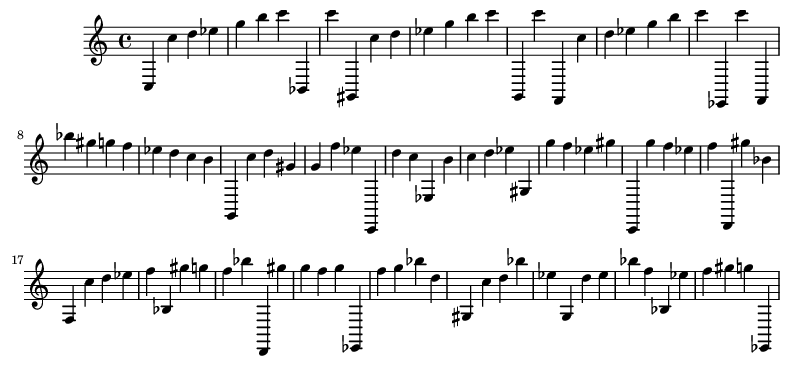

In [ ]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))

def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)

Examine all the notes in the Corpus

In [ ]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 377


In [ ]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 2886.8567639257294
Most frequent note in Corpus appeared: 48431 times
Least frequent note in Corpus appeared: 3 time


#Exploring the notes dictionary


# 1. Convolutional Neural Networks (CNN)

## Loading Data

In [ ]:
# Define globals
data_directory = 'C:/Users/kflin/Downloads/song_data' #dataset path
fs = 5  # Sampling frequency for piano rolls
labeled_midi_data = {}

def load_midi_data_and_labels(directory):
    skipped_files = []    # Keep track of skipped files due to errors
    data = []
    composers = []
    num_composer_map = {}
    # Function to recursively iterate files in a directory
    def iterate_dir(dir_path, label, composer):
        # Check direct .mid files in current directory
        for item in os.listdir(dir_path):
            item_path = os.path.join(dir_path, item)
            if os.path.isfile(item_path) and item_path.endswith('.mid'):
                try:
                    # Load the MIDI file
                    midi_data = pretty_midi.PrettyMIDI(item_path)
                    data.append(midi_data)
                    composers.append(label)
                    if label not in labeled_midi_data:
                        labeled_midi_data[label] = []
                    labeled_midi_data[label].append(midi_data)

                except Exception as e:  # Catch any exception that might be raised
                    #print(f"Skipping file {item_path} due to an error: {e}")
                    skipped_files.append(item_path)
            elif os.path.isdir(item_path):
                iterate_dir(item_path, label, composer)
        #print(f"Number of files skipped due to error: {len(skipped_files)}")
        return

    # Process each composer's directory in the root directory
    for label, composer in enumerate(sorted(os.listdir(directory))):
        composer_path = os.path.join(directory, composer)
        if os.path.isdir(composer_path):
            num_composer_map[label] = composer
            iterate_dir(composer_path, label, composer)

    return np.array(data), np.array(composers), num_composer_map

_, _, num_composer_map = load_midi_data_and_labels(data_directory)

# print number of songs per composer
for composer, songs in labeled_midi_data.items():
    print(f"Composer {composer} has {len(songs)} songs")

c:\Users\kflin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Composer 0 has 925 songs
Composer 1 has 211 songs
Composer 2 has 136 songs
Composer 3 has 256 songs


## Preprocess Song Data for CNN

In [ ]:
# SongData object. Contains the composer name, the composer id, the midi data, the piano roll, and the windows of the piano roll
class Song:
    def __init__(self, composer, composer_id, midi_data):
        self.composer = composer
        self.composer_id = composer_id
        self.midi_data = midi_data
        self.piano_roll = self.create_piano_roll()
        self.windows = []

    def create_piano_roll(self):
        piano_roll = self.midi_data.get_piano_roll(fs=fs)
        return piano_roll

    def augment_data(self):
        augmented_piano_rolls = []
        # Shift the piano roll up and down
        for i in range(-3,3):
            augmented_piano_rolls.append(np.roll(self.piano_roll, i, axis=0))

        return augmented_piano_rolls

    def create_windows(self, window_size=256, stride=256):
        piano_roll_tensor = tf.convert_to_tensor(self.piano_roll)
        width = piano_roll_tensor.shape[1]
        starts = tf.range(0, width - window_size, stride)
        windows = tf.stack([piano_roll_tensor[:, start:start + window_size] for start in starts], axis=0)
        self.windows = windows

    def create_windows_with_augmentation(self, window_size=256, stride=256):
        augmented_piano_rolls = self.augment_data()
        windows = []
        for piano_roll in augmented_piano_rolls:
            piano_roll_tensor = tf.convert_to_tensor(piano_roll)
            width = piano_roll_tensor.shape[1]
            starts = tf.range(0, width - window_size, stride)
            windows.extend([piano_roll_tensor[:, start:start + window_size] for start in starts])
        self.windows = windows

    def print_piano_roll(self):
        plt.figure(figsize=(12, 6))
        plt.imshow(self.piano_roll, origin='lower', aspect='auto', cmap='gray')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Pitch')
        plt.title('Piano Roll Representation of MIDI File')
        plt.show()

    def print_info(self):
        print(f"Composer: {self.composer}")
        print(f"Composer ID: {self.composer_id}")
        print(f"Number of windows: {len(self.windows)}")
        print(f"Window shape: {self.windows[0].shape}")

1528


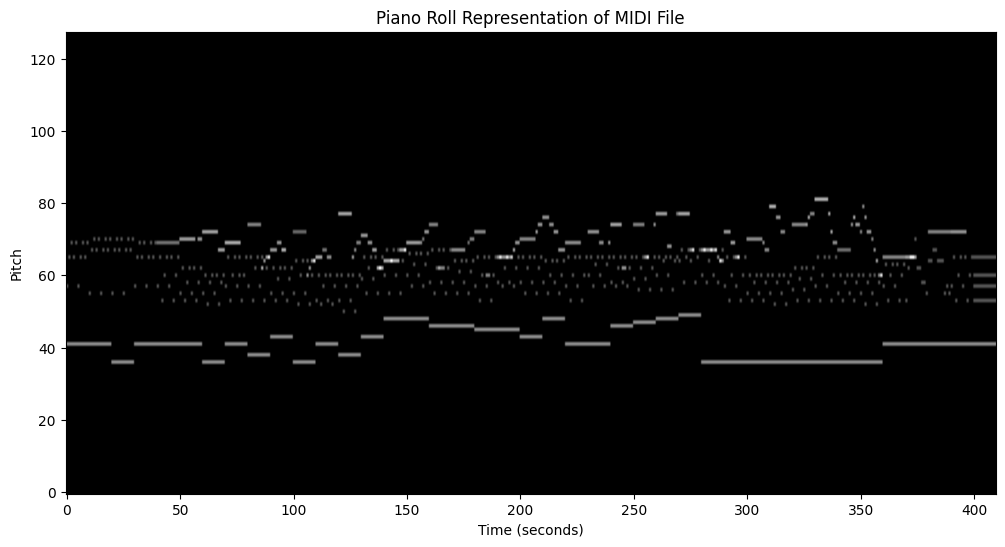

In [ ]:
songs = []

for composer_id, composer in labeled_midi_data.items():
    for midi_data in composer:
        song = Song(num_composer_map[composer_id], composer_id, midi_data)
        songs.append(song)

print(len(songs))

song = songs[0]
song.print_piano_roll()

Min length: 87
max_length: 25840
Number of songs: 1076


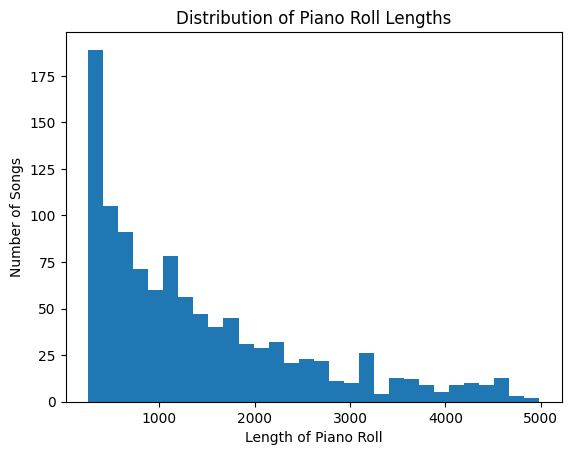

In [ ]:
## find min and max length of piano roll
min_length = 999999
max_length = 0

for song in songs:
    if song.piano_roll.shape[1] < min_length:
        min_length = song.piano_roll.shape[1]
    if song.piano_roll.shape[1] > max_length:
        max_length = song.piano_roll.shape[1]

songs = [song for song in songs if song.piano_roll.shape[1] <= 5000]
songs = [song for song in songs if song.piano_roll.shape[1] >= 256]

print(f"Min length: {min_length}")
print(f"max_length: {max_length}")
print(f"Number of songs: {len(songs)}")

# plot distribution of lengths
lengths = [song.piano_roll.shape[1] for song in songs]
plt.hist(lengths, bins=30)
plt.xlabel('Length of Piano Roll')
plt.ylabel('Number of Songs')
plt.title('Distribution of Piano Roll Lengths')
plt.show()

In [ ]:
# buckets for composer
buckets_songs = {}

# print number of songs per composer
for song in songs:
    if song.composer not in buckets_songs:
        buckets_songs[song.composer] = 0
    buckets_songs[song.composer] += 1

# print number of songs per composer
for composer, song_count in buckets_songs.items():
    print(f"Composer {composer} has {song_count} songs")

# create windows for each song
i = 0
for song in songs:
    i += 1
    song.create_windows_with_augmentation()
    # progress
    print(f"{i} songs processed", end='\r')

buckets_windows = {}
# get windows for each composer
for song in songs:
    if song.composer not in buckets_windows:
        buckets_windows[song.composer] = 0
    buckets_windows[song.composer] += len(song.windows)

# print number of windows per composer
for composer, windows in buckets_windows.items():
    print(f"Composer {composer} has {windows} windows")

Composer Bach has 541 songs
Composer Beethoven has 175 songs
Composer Chopin has 122 songs
Composer Mozart has 238 songs
Composer Bach has 11910 windows
Composer Beethoven has 7986 windows
Composer Chopin has 2922 windows
Composer Mozart has 9714 windows


## Train Test Split

In [ ]:
train_songs = {}
test_songs = {}

# shuffle songs with seed
np.random.seed(42)
np.random.shuffle(songs)

for song in songs:
    if song.composer_id not in test_songs:
        test_songs[song.composer_id] = []
    if len(test_songs[song.composer_id]) < 30:
        test_songs[song.composer_id].append(song)
    else:
        if song.composer_id not in train_songs:
            train_songs[song.composer_id] = []
        train_songs[song.composer_id].append(song)

train_songs = [song for composer_songs in train_songs.values() for song in composer_songs]
test_songs = [song for composer_songs in test_songs.values() for song in composer_songs]

# print number of training and testing songs for each composer
count_train = {}
count_test = {}

for song in train_songs:
    if song.composer_id not in count_train:
        count_train[song.composer_id] = 0
    count_train[song.composer_id] += 1

for song in test_songs:
    if song.composer_id not in count_test:
        count_test[song.composer_id] = 0
    count_test[song.composer_id] += 1

print(f"Training songs per composer{count_train}")
print(f"Testing songs per composer{count_test}")

# Create a dataset from the training songs
train_windows = []
train_labels = []

for song in train_songs:
    train_windows.extend(song.windows)
    train_labels.extend([song.composer_id] * len(song.windows))

train_windows = tf.stack(train_windows)
train_labels = tf.convert_to_tensor(train_labels)

print(f"Training windows shape: {train_windows.shape}")
print(f"Training labels shape: {train_labels.shape}")
unique, counts = np.unique(train_labels, return_counts=True)
print(f"Distinct Training Samples {dict(zip(unique, counts))}")

test_windows = []
test_labels = []

for song in test_songs:
    test_windows.extend(song.windows)
    test_labels.extend([song.composer_id] * len(song.windows))

test_windows = tf.stack(test_windows)
test_labels = tf.convert_to_tensor(test_labels)

print(f"Testing windows shape: {test_windows.shape}")
print(f"Testing labels shape: {test_labels.shape}")
unique, counts = np.unique(test_labels, return_counts=True)
print(f"Distinct Testing Samples {dict(zip(unique, counts))}")

print(train_labels)

Training songs per composer{0: 511, 3: 208, 1: 145, 2: 92}
Testing songs per composer{3: 30, 1: 30, 2: 30, 0: 30}
Training windows shape: (28554, 128, 256)
Training labels shape: (28554,)
Distinct Training Samples {0: 11334, 1: 6678, 2: 2124, 3: 8418}
Testing windows shape: (3978, 128, 256)
Testing labels shape: (3978,)
Distinct Testing Samples {0: 576, 1: 1308, 2: 798, 3: 1296}
tf.Tensor([0 0 0 ... 2 2 2], shape=(28554,), dtype=int32)


In [ ]:
# Convert train_windows and train_labels to numpy arrays
train_windows_np = train_windows.numpy()
train_labels_np = train_labels.numpy()

# SMOTE wants 2D input, need to flatten
n_samples, n_timesteps, n_features = train_windows_np.shape
train_windows_reshaped = train_windows_np.reshape((n_samples, -1))

smote = SMOTE(random_state=42)
train_windows_resampled, train_labels_resampled = smote.fit_resample(train_windows_reshaped, train_labels_np)

# Reshape the resampled windows back to 3D
train_windows_resampled = train_windows_resampled.reshape((-1, n_timesteps, n_features))

# Convert back to tensors
train_windows_balanced = tf.convert_to_tensor(train_windows_resampled)
train_labels_balanced = tf.convert_to_tensor(train_labels_resampled)

print(f"Balanced training windows shape: {train_windows_balanced.shape}")
print(f"Balanced training labels shape: {train_labels_balanced.shape}")
unique, counts = np.unique(train_labels_balanced, return_counts=True)
print(f"Distinct Balanced Training Samples {dict(zip(unique, counts))}")

Balanced training windows shape: (45336, 128, 256)
Balanced training labels shape: (45336,)
Distinct Balanced Training Samples {0: 11334, 1: 11334, 2: 11334, 3: 11334}


## Build and Train Model

In [ ]:
train_windows = tf.expand_dims(train_windows, axis=-1)
test_windows = tf.expand_dims(test_windows, axis=-1)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', input_shape=(128, 256, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 124, 252, 64)   │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 62, 126, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 58, 122, 128)   │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 29, 61, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 25, 57, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 43008)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     2,752,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,369,156 (12.85 MB)

 Trainable params: 3,369,156 (12.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_windows, train_labels, epochs=3, batch_size=32, validation_data=(test_windows, test_labels))

c:\Users\kflin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
893/893 ━━━━━━━━━━━━━━━━━━━━ 401s 447ms/step - accuracy: 0.6018 - loss: 1.4533 - val_accuracy: 0.6252 - val_loss: 0.8840
Epoch 2/3
893/893 ━━━━━━━━━━━━━━━━━━━━ 399s 447ms/step - accuracy: 0.8109 - loss: 0.4787 - val_accuracy: 0.6116 - val_loss: 1.4019
Epoch 3/3
893/893 ━━━━━━━━━━━━━━━━━━━━ 399s 447ms/step - accuracy: 0.8771 - loss: 0.3201 - val_accuracy: 0.6227 - val_loss: 1.4094


## Evaluate Model By Window Classification

125/125 - 16s - 128ms/step - accuracy: 0.6227 - loss: 1.4094
Test accuracy: 0.6226747035980225
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step


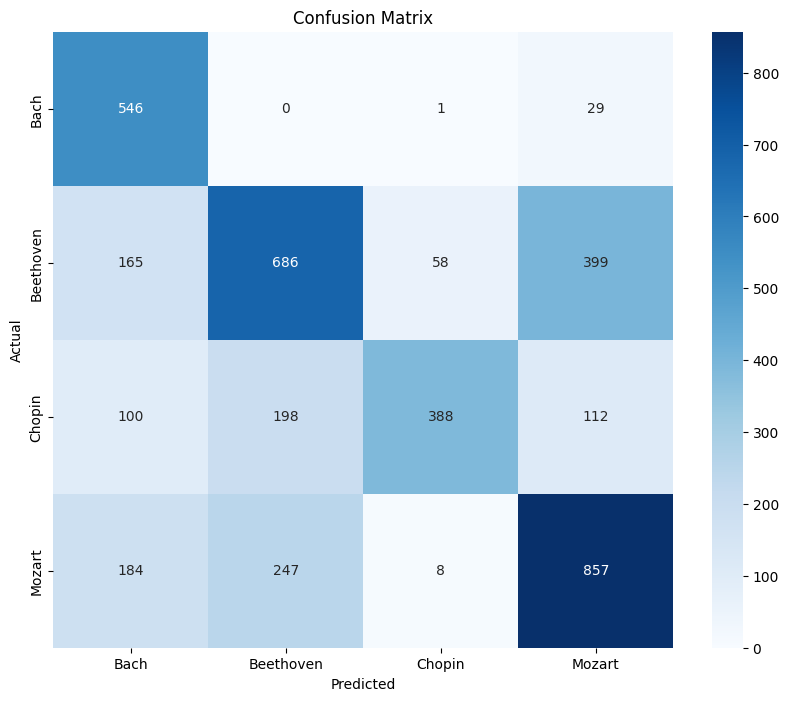

In [ ]:
test_loss, test_acc = model.evaluate(test_windows, test_labels, verbose=2)
print('Test accuracy:', test_acc)

predictions = model.predict(test_windows)
predictions = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels, predictions, )
cm_df = pd.DataFrame(cm, index=num_composer_map.values(), columns=num_composer_map.values())

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Evaluate Model By Song Classification

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/st

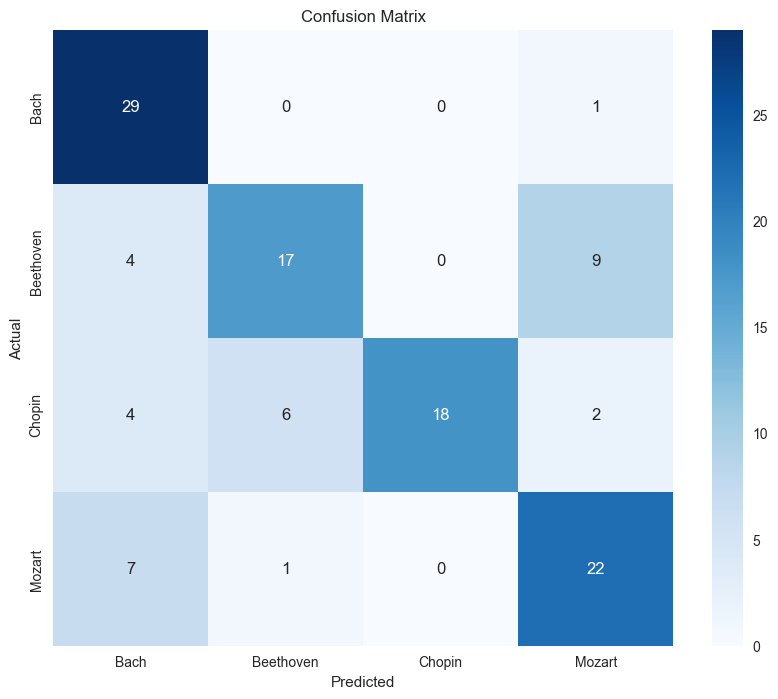

In [ ]:
def predict_song(model, song_windows):
    song_windows = tf.expand_dims(song_windows, axis=-1)
    window_predictions = model.predict(song_windows)
    summed_predictions = np.sum(window_predictions, axis=0)
    predicted_composer_id = np.argmax(summed_predictions)
    return predicted_composer_id

song_predictions = []
song_true_labels = []

for song in test_songs:
    predicted_composer_id = predict_song(model, song.windows)
    song_predictions.append(predicted_composer_id)
    song_true_labels.append(song.composer_id)

print(classification_report(song_true_labels, song_predictions, target_names=num_composer_map.values()))

cm = confusion_matrix(song_true_labels, song_predictions)
cm_df = pd.DataFrame(cm, index=num_composer_map.values(), columns=num_composer_map.values())

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 2. Long Short-Term Memory networks(LSTM) Method

In [ ]:
# Declare class to encapsulate LSTM functionality (feature extraction/model/evaluation/prediction/visualization)
class ComposerClassification_LSTM_Ngram:
    # Initialize class elements.
    def __init__(self, dataset, labels, composer_map):
        self.composer_data = np.array(dataset)
        self.composer_labels = np.array(labels)
        self.tokenizer = None
        self.lstm_model = None
        self.composer_map = composer_map
        self.sequence_length = 100

    # Shuffle the augmented data few times
    def shuffle_data(self):
        for i in range(2):
          print("Shuffle:", i)
          # shuffled indices
          indices = np.arange(self.composer_data.shape[0])
          np.random.shuffle(indices)
          # Shuffling with same indices
          self.composer_data   = self.composer_data[indices]
          self.composer_labels = self.composer_labels[indices]

    # Split the midi_data_augmented data into two part one is to
    # train and validate the model and other is to test the model before any data pre-processing and feature extraction.
    def keep_unprocessed_data_for_prediction(self, percent = 0.2):
        # Calculate split index for 80/20 split
        split_index = int(len(self.composer_data) * (1-0.2))

        self.composer_data_Train, self.composer_data_Test = np.split(self.composer_data, [split_index])


        self.composer_labels_Train, self.composer_labels_Test = np.split(self.composer_labels, [split_index])

        print("Train Size:", len(self.composer_data_Train), len(self.composer_labels_Train))

        print("Test Size:", len(self.composer_data_Test), len(self.composer_labels_Test))
        return (self.composer_data_Train,  self.composer_labels_Train), (self.composer_data_Test, self.composer_labels_Test)

    # Plot labels
    def plot_train_test_labels(self):
        # Plot after rangom shuffles three times
        plt.figure(figsize=(8, 6))
        plt.plot(self.composer_labels_Train,'ro',  label='Train labels')
        plt.plot(self.composer_labels_Test ,'bo', label='Test labels')

        # Adding title and labels
        plt.title('label variations in train/test ')
        plt.xlabel('Index')
        plt.ylabel('label')
        plt.legend()
        plt.show()

    # Function to extract pitch sequences from a MIDI file
    def extract_pitch_sequences(self, mdata):
        sequences = []
        # Considering all instruments
        for i in np.arange(len(mdata.instruments)):
            previous_pitch = None
            instrument = mdata.instruments[i]
            if not instrument.is_drum:
                #pitches = [note.pitch for note in instrument.notes]
                # pitches.append(instrument.program)
                tokens = []
                for note in instrument.notes:
                    current_pitch = note.pitch
                    if previous_pitch is not None:
                        interval = current_pitch - previous_pitch
                    else:
                        interval = 0  # No interval for the first note
                    # Create new token by making a touple of pitch and pitch difference from previous
                    #token = (current_pitch, interval)
                    # Create new token by adding differnce from previos pitch to the token
                    # token = current_pitch + interval
                    # Create new token by concatenating current_pitch and interval as strings
                    token = str(current_pitch) + str(interval)
                    tokens.append(token)
                    previous_pitch = current_pitch

                sequences.extend(tokens)
        return sequences

    # create tokens of length sequence_length
    def create_n_grams(self, sequences, n):
        # Check if the sequence is shorter than the desired n-gram length
        if len(sequences) < n:
            # Pad the sequence with zeros at the end
            sequences = sequences + [0] * (n - len(sequences))
        # Generate n-grams
        return [' '.join(map(str, sequences[i:i+n])) for i in range(len(sequences) - n + 1)]

    # Extract features and labels from full train_set
    def create_sequence(self, sequence_len):
        self.sequence_length = sequence_len
        all_n_grams = []
        labels = []
        for data, composer in zip(self.composer_data_Train,self.composer_labels_Train):
            sequences = self.extract_pitch_sequences(data)
            # Ignore short sequences
            if(len(sequences) < self.sequence_length):
                print("Short sequence for ", composer)
                continue
            n_grams = self.create_n_grams(sequences,self.sequence_length)
            all_n_grams.extend(n_grams)
            labels.extend([composer] * len(n_grams))

        # Tokenization and sequence padding
        self.tokenizer = Tokenizer()
        self.tokenizer.fit_on_texts(all_n_grams)
        sequences = self.tokenizer.texts_to_sequences(all_n_grams)
        data = pad_sequences(sequences, maxlen=self.sequence_length)
        return (data, labels)

    # Save tokenizer. Same tokeniser should be used when testing the composer
    def save_tokenizer(self):
        # After training and creating the tokenizer
        self.tokenizer_name = 'tokenizer.pickle'
        with open(self.tokenizer_name, 'wb') as handle:
            pickle.dump(self.tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
            print("Saved tokenizer", self.tokenizer_name)

    # Split dataset for model training, validation, testing
    def splitDataset_train_val_test(self, data, labels, test_size=0.30):
       # Splitting the dataset
        self.X_train_sequence, X_temp, self.y_train_sequence, y_temp = train_test_split(data, labels, test_size=0.30, random_state=42)
        self.X_val_sequence,  self.X_test_sequence,  self.y_val_sequence,  self.y_test_sequence = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
        print("Train, val, test size", len(self.X_train_sequence), len(self.X_val_sequence), len(self.X_test_sequence) )
        # Label encoding
        label_encoder = LabelEncoder()
        self.y_train_sequence = label_encoder.fit_transform(self.y_train_sequence)
        self.y_val_sequence = label_encoder.transform(self.y_val_sequence)
        self.y_test_sequence  = label_encoder.transform( self.y_test_sequence )
        return

    def build_lstm2_model(self, input_dim, num_classes):
        self.lstm_model = Sequential([
            #Embedding(input_dim=input_dim, output_dim=64, input_length=self.sequence_length),
            Embedding(input_dim=input_dim, output_dim=64),
            LSTM(128, return_sequences=True),
            LSTM(128),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
        # Compile the model
        self.lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return self.lstm_model

    def train_evaluate_model(self, epochs=10, batch_size=256):
        # Train the model
        history = self.lstm_model.fit(self.X_train_sequence, self.y_train_sequence, epochs=epochs,
                                 batch_size=batch_size, validation_data=(self.X_val_sequence, self.y_val_sequence))
        test_loss, test_accuracy = self.lstm_model.evaluate(self.X_test_sequence, self.y_test_sequence)
        print("Test accuracy:", test_accuracy)
        print("Test loss:", test_loss)
        return history

    def plot_results(self, history):
        # Extracting performance metrics
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        epochs = range(1, len(acc) + 1)
        # Plotting all metrics
        plt.figure(figsize=(12, 8))
        plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
        plt.plot(epochs, val_acc, 'go-', label='Validation Accuracy')

        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    # Load the same tokenizer used to train the data
    def loadTokenizer(self):
        with open(self.tokenizer_name, 'rb') as handle:
            self.tokenizer = pickle.load(handle)
            return self.tokenizer

    # Predict from single midifile
    def predict_composer(self, testMidi):
        print("predict_composer")
        # Extract pitch sequences from the MIDI file
        sequences = self.extract_pitch_sequences(testMidi)
        n_grams = self.create_n_grams(sequences)

        # Tokenize and pad the sequences
        tokenizer = self.loadTokenizer()
        sequences = tokenizer.texts_to_sequences(n_grams)
        padded_sequences = pad_sequences(sequences, maxlen=self.sequence_length)

        # Make predictions
        predictions = self.lstm_model.predict(padded_sequences)
        predicted_index = np.argmax(predictions, axis=1)  #  multiple predictions: take the most common
        #predicted_composer = label_encoder.inverse_transform([np.bincount(predicted_index).argmax()])
        return predicted_index

    # test single midi file
    def testComposer(self, testMidi, actualLabel):
        composer_n_grams = []
        composer_label = []
        sequences = self.extract_pitch_sequences(testMidi)
        n_grams = self.create_n_grams(sequences)
        composer_n_grams.extend(n_grams)
        composer_label.extend([composer] * len(n_grams))
        # Tokenization and sequence padding
        tokenizer = self.loadTokenizer()
        sequences = tokenizer.texts_to_sequences(composer_n_grams)
        data = pad_sequences(sequences, maxlen=self.sequence_length)
        return data

    # Predict single composer
    def test_predict(self, midi_index=0):
        test_midi = self.composer_data[midi_index]
        actualLabel = self.composer_labels[midi_index]
        print(type(test_midi))
        predicted_composer_index = self.predict_composer(test_midi)
        count = Counter(predicted_composer_index)
        sorted_composer = count.most_common()
        print("Get highest probability of composer:")
        for e, f in sorted_composer:
            print(f"Element: {e}, Frequency: {f}")

        most_frequent = sorted_composer[0][0]
        print(f"Actual composer= {self.composer_map[actualLabel]},\nThe predicted composer is: {self.composer_map[most_frequent]}")

    ## Predict on unseen test set and evaluate the model
    def evaluate_unseen_dataset(self):
        predicted_composer = []
        # Load Tokenize
        tokenizer = self.loadTokenizer()
        all_n_grams_test = []
        labels_test = []
        skip_short_seq = []
        i = 0
        for index, (data, composer) in enumerate(zip(self.composer_data_Test,self.composer_labels_Test)):
            #print("composer ", composer, i)
            sequences = self.extract_pitch_sequences(data)
            # Ignore short sequences
            if(len(sequences) < self.sequence_length):
                print("Short sequence for ", composer)
                skip_short_seq.append(index)
                continue
            n_grams = self.create_n_grams(sequences, self.sequence_length)

            all_n_grams_test.extend(n_grams)
            labels_test.extend([composer] * len(n_grams))

            pitch_token = tokenizer.texts_to_sequences(n_grams)
            padded_sequences = pad_sequences(pitch_token, maxlen=self.sequence_length)

            # Make predictions
            predictions = self.lstm_model.predict(padded_sequences, verbose=0)
            predicted_index = np.argmax(predictions, axis=1)  #  multiple predictions: take the most common
            predicted_result = mode(predicted_index)
            predicted_composer.append(predicted_result.mode)
            i = i+ 1
        # Remove the rows in skip_short_seq
        self.composer_labels_Test = np.delete(self.composer_labels_Test, skip_short_seq)
        return predicted_composer

    # Generate visual representation of class results (confusion matrix)
    def generate_report(self, predictions):
        print(classification_report(self.composer_labels_Test, predictions))

        # Confusion matix
        cm = confusion_matrix(self.composer_labels_Test, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bach' , 'Beethoven', 'Chopin', 'Mozart'], yticklabels=['Bach' , 'Beethoven', 'Chopin', 'Mozart'])
        plt.title('Confusion matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        return


## LSTM Data Pre-processing and Feature Extraction:

Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.

In [ ]:
lstm_classification = ComposerClassification_LSTM_Ngram(midi_data_augmented, composer_labels_augmented, composer_map)

In [ ]:
lstm_classification.shuffle_data()

Shuffle: 0
Shuffle: 1


In [ ]:
(train_set, test_set) = lstm_classification.keep_unprocessed_data_for_prediction()
print("Train set:", train_set[0].shape, "Test set:", test_set[0].shape)

Train Size: 1116 1116
Test Size: 279 279
Train set: (1116,) Test set: (279,)


In [ ]:
print(lstm_classification.composer_data.shape, lstm_classification.composer_labels.shape)

(1395,) (1395,)


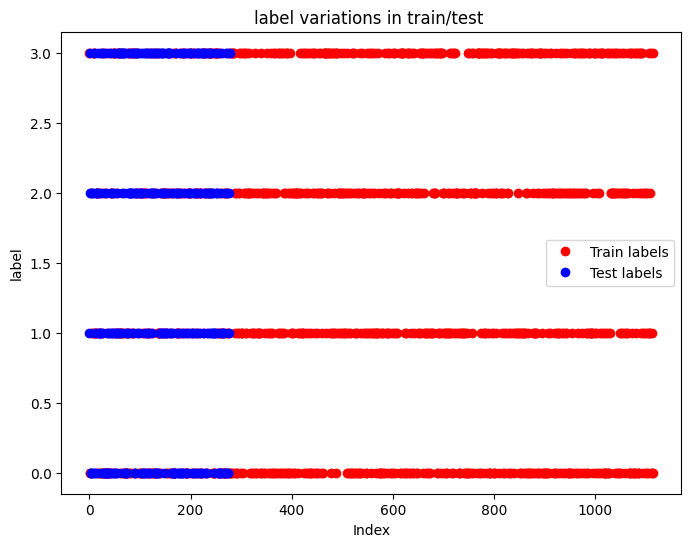

In [ ]:
lstm_classification.plot_train_test_labels()

In [ ]:
seq_length = 100
data, labels = lstm_classification.create_sequence(seq_length)
print("Data:", len(data), "labels:", len(labels))

Short sequence for  1
Data: 4683407 labels: 4683407


In [ ]:
lstm_classification.save_tokenizer()

Saved tokenizer tokenizer.pickle


In [ ]:
lstm_classification.splitDataset_train_val_test(data, labels)

Train, val, test size 3278384 702511 702512


## LSTM Model Building:

Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.

In [ ]:
input_dim = len(np.unique(data, axis=0))
output_dim = len(np.unique(labels))

In [ ]:
# Build the lstm model with embedding layer as first layer.
lstm_model = lstm_classification.build_lstm2_model(input_dim, output_dim)

## LSTM Model Architecture

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 64)             │     199,439,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 199,670,340 (761.68 MB)

 Trainable params: 199,670,340 (761.68 MB)

 Non-trainable params: 0 (0.00 B)

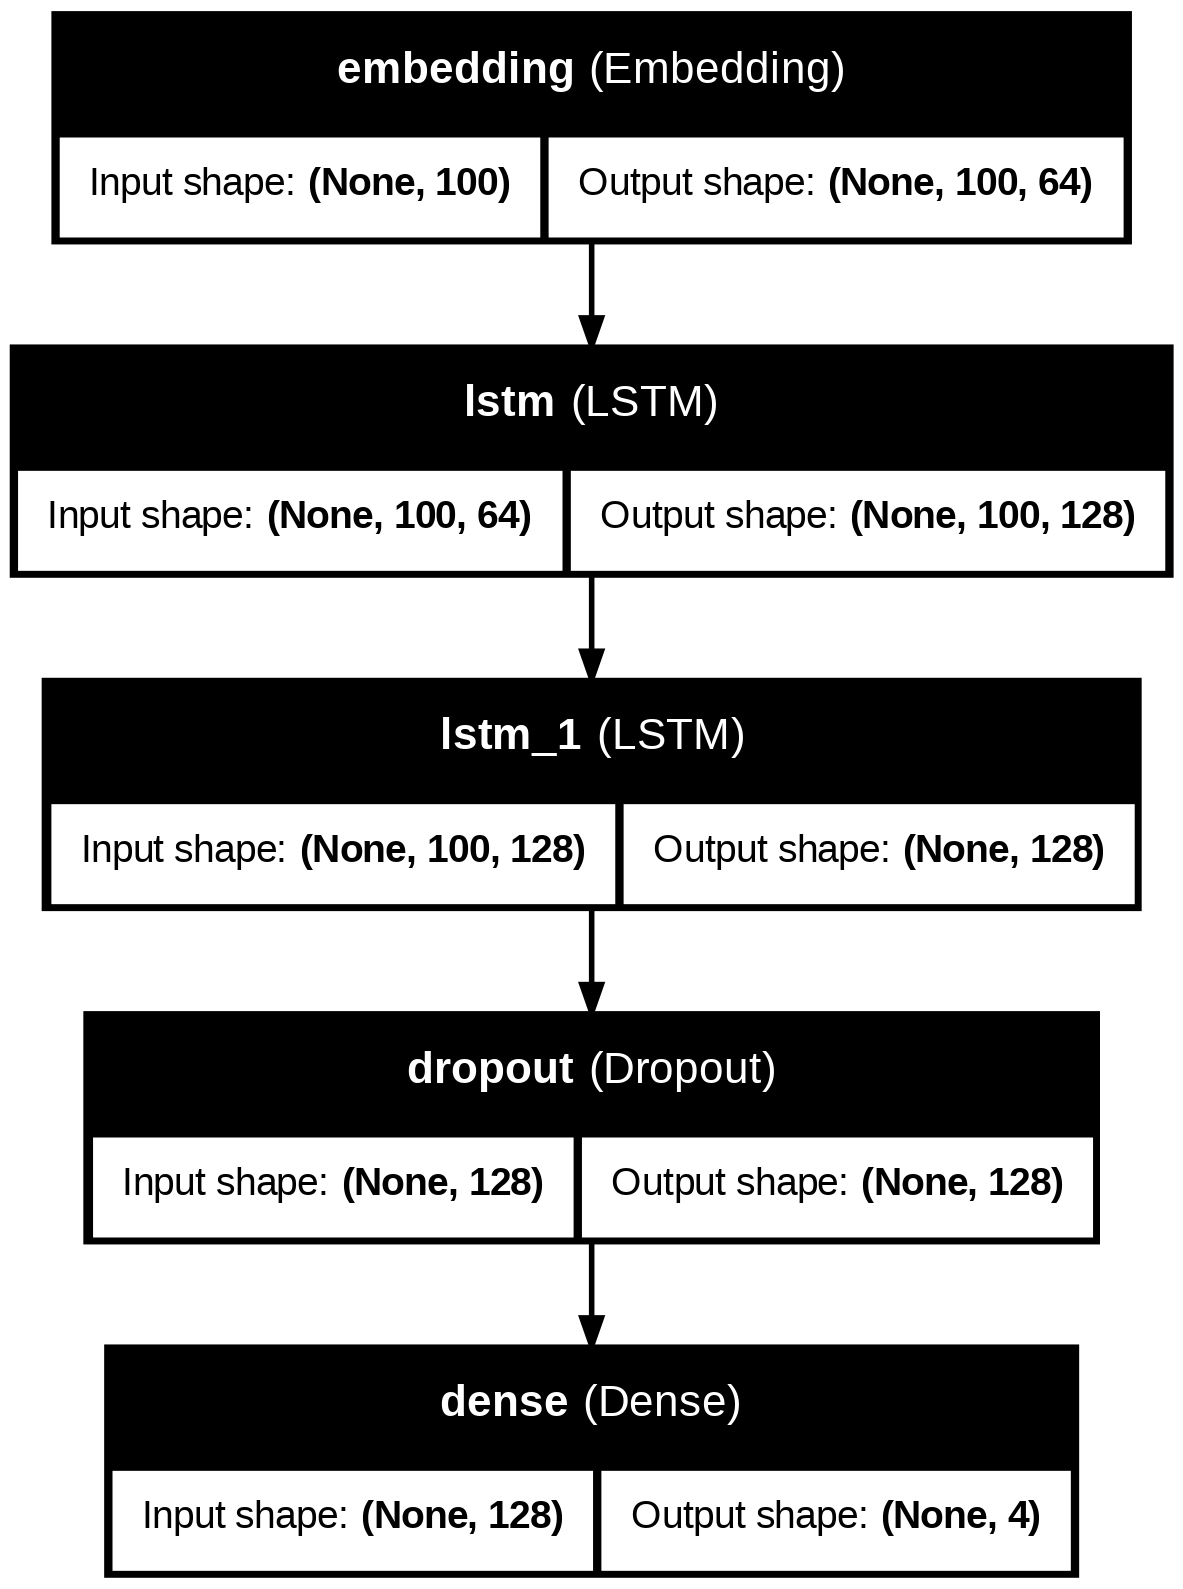

In [ ]:
# Create model summary and visualize
# None for batch size, sequence_length for feature size
lstm_model.build((None, sequence_length))
lstm_model.summary()
plot_model(lstm_model, show_shapes=True, show_layer_names=True)

## LSTM Model Training

For LSTM model we use sparse_categorical_crossentropy as the loss function. This loss function is designed to handle integer targets directly, interpreting the integer as the index of the true class.


In [ ]:
history = lstm_classification.train_evaluate_model(epochs=10, batch_size=256)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 199439424 elements. This may consume a large amount of memory.
  warnings.warn(


12807/12807 ━━━━━━━━━━━━━━━━━━━━ 391s 30ms/step - accuracy: 0.6840 - loss: 0.7224 - val_accuracy: 0.9309 - val_loss: 0.1924
Epoch 2/10
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 387s 30ms/step - accuracy: 0.9500 - loss: 0.1431 - val_accuracy: 0.9810 - val_loss: 0.0541
Epoch 3/10
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 388s 30ms/step - accuracy: 0.9836 - loss: 0.0477 - val_accuracy: 0.9897 - val_loss: 0.0296
Epoch 4/10
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 391s 31ms/step - accuracy: 0.9901 - loss: 0.0288 - val_accuracy: 0.9911 - val_loss: 0.0254
Epoch 5/10
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 391s 31ms/step - accuracy: 0.9926 - loss: 0.0217 - val_accuracy: 0.9937 - val_loss: 0.0180
Epoch 6/10
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 387s 30ms/step - accuracy: 0.9938 - loss: 0.0181 - val_accuracy: 0.9947 - val_loss: 0.0149
Epoch 7/10
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 388s 30ms/step - accuracy: 0.9948 - loss: 0.0152 - val_accuracy: 0.9948 - val_loss: 0.0148
Epoch 8/10
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 387s 30ms/step - accur

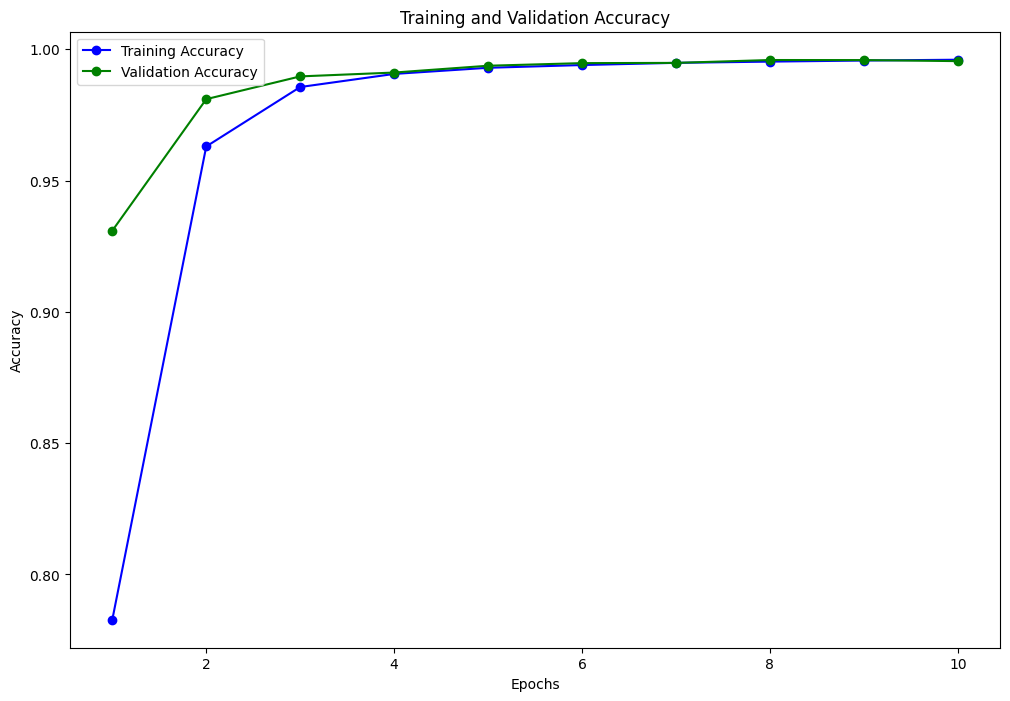

In [ ]:
lstm_classification.plot_results(history)

## LSTM Model Evaluation

In [ ]:
predictions = lstm_classification.evaluate_unseen_dataset()

              precision    recall  f1-score   support

           0       0.97      0.91      0.94        75
           1       0.84      0.92      0.88        62
           2       0.97      1.00      0.99        70
           3       0.94      0.90      0.92        72

    accuracy                           0.93       279
   macro avg       0.93      0.93      0.93       279
weighted avg       0.93      0.93      0.93       279



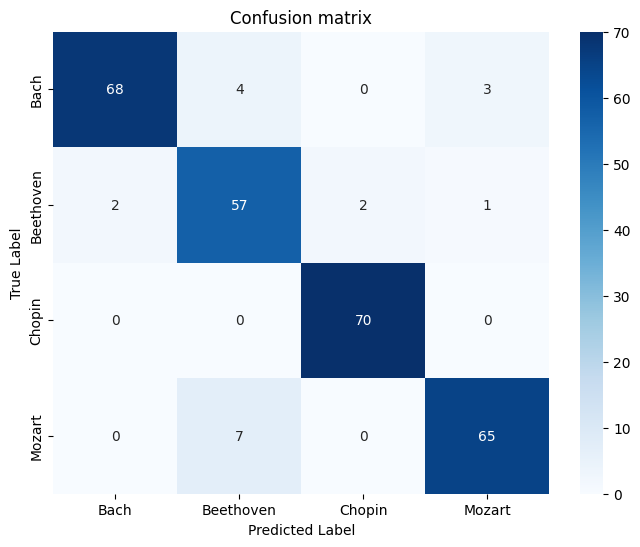

In [ ]:
lstm_classification.generate_report(predictions)

In [ ]:
#lstm_classification.test_predict(midi_index=0)

## LSTM Model Optimization:

We performed parameter tuning to determine the optimal settings for our LSTM-based classification model. We evaluated the model's performance across  different configurations by varying the batch size, epoch and sequence length. Initially, with a batch size of 128 and sequence length from 10 to 100, the model achieved a test accuracy of 75% to 85% over 10 epochs. Upon increasing the batch size to 256 and the sequence length to 100, there was a notable improvement in test accuracy, which rose to 92%. This indicated that moderate increases in these parameters could significantly enhance the model's learning capacity. However, further increasing the batch size to 512 and the sequence length to 100 saw the test accuracy drop slightly to 88%, suggesting potential diminishing returns from larger batch sizes and sequence lengths. This series of tests revealed that while larger sequence lengths and batch sizes generally improve performance, there is an optimal point beyond which increases may not yield proportional gains in accuracy. The optimal configuration identified was a batch size of 256 and a sequence length of 100.

| Batch Size | Sequence length | epochs  | Test accuracy |
|:----------:|:---------------:|:-------:|:-------------:|
| 128        | 10 to 100       | 10      | 75 to 85%     |
| 256        | 100             | 10      | 92%           |
| 512        | 100             | 10      | 88%           |